In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.sparse as spr
%matplotlib inline

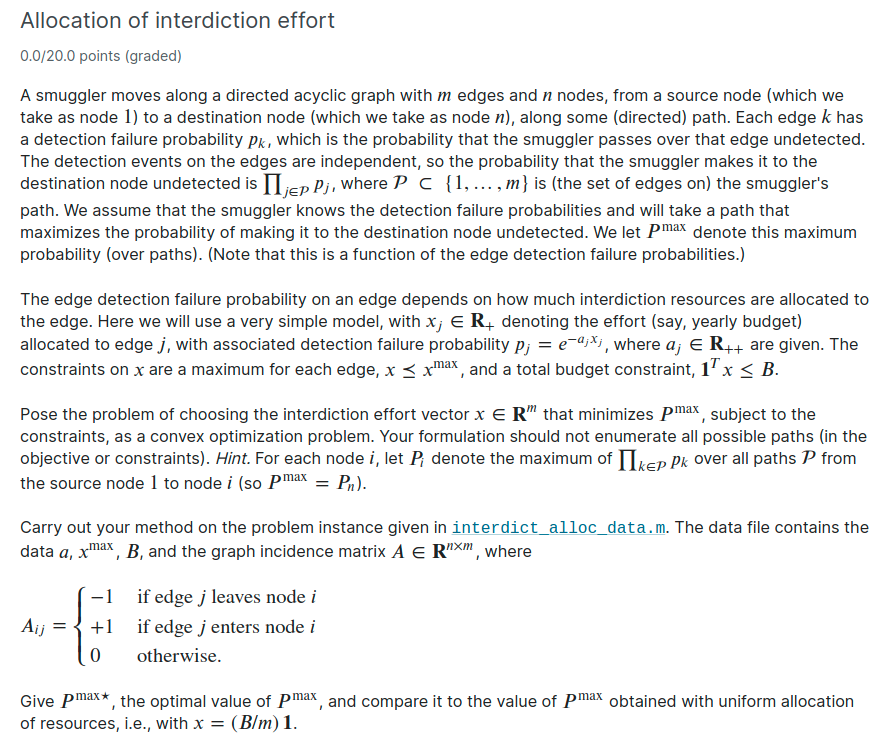

# Formulation

Lets consider the edges weights as the log-prob so that for every path P:  
$w'(P) = log(w(P)) =  log(\prod_{j \in P}{p_j}) = \sum_{j \in P}{log(p_j)} = \sum_{j \in P}{-a_jx_j}$

This doesn't affect $P^{max}$ since log is a monotonic increasing transformation.

So the problem is to choose x that minimizes the maximum distance from 1 to n in the given DAG.  
The maximum distance can be calculated by dynamic programming.

$d[u] = \max\{d[v] + w(v,u) | (v,u) \in E(G)\} \quad , \text{ and } d[source] = 0$

---
Minimize $d[n]$  
s.t  
$d[1] = 0$  
$d[u] \geq d[v] -a_jx_j \quad, \forall \text{ edge } j = v \rightarrow u$  
$\sum x_j \leq B$  
$0 \leq x \leq x^{max}$

---
with incidence matrix:

$d[u] - d[v] \geq -a_jx_j \leftrightarrow A^Td \geq -ax$

# Problem data

In [2]:
A = np.loadtxt("incidence_matrix.csv", delimiter = ',', dtype = int)
A = spr.csr_matrix(A)
n , m = A.shape
x_max = np.loadtxt("x_max.csv", delimiter = ',')
assert x_max.shape == (m,)
a = np.loadtxt("edge_factor.csv", delimiter = ',')
assert a.shape == (m,)
B = np.loadtxt("total_budget.csv", delimiter = ',')
assert B.shape == ()
B = float(B)

# Solving

In [3]:
d = cp.Variable(n)
x = cp.Variable(m, nonneg = True)

C = [
    d[0] == 0,
    A.T @ d >= -cp.multiply(a,x), 
    cp.sum(x) <= B, 
    x <= x_max,
]
obj = cp.Minimize(d[n-1])
prob = cp.Problem(obj,C)
prob.solve()
assert prob.status == cp.OPTIMAL
print(prob.value)
print("distances:\n", d.value)

-3.1399674116216807
distances:
 [ 9.39023695e-17 -1.08691317e+00 -6.25399858e-01 -1.08691317e+00
 -1.71975529e+00 -6.25399858e-01 -2.15314665e+00 -2.15314665e+00
 -2.15314665e+00 -3.13996741e+00]


In [4]:
p_max = np.exp(d[n-1].value)
print("P_max:", p_max)

P_max: 0.043284208441142114


Baseline : uniform allocation

In [5]:
C2 = [
    d[0] == 0,
    A.T @ d >= -cp.multiply(a,x), 
    x == B/m,     
]
prob = cp.Problem(obj,C2)
prob.solve()
assert prob.status == cp.OPTIMAL
print(prob.value)
print("distances:\n", d.value)

-1.398119609637897
distances:
 [ 3.60578783e-16 -2.31361085e-01 -2.31138514e-01 -5.17610130e-01
 -5.24513474e-01 -2.49642157e-01 -8.87594949e-01 -9.87849403e-01
 -1.01418372e+00 -1.39811961e+00]


In [6]:
print("uniform allocation P_max:",np.exp(d[n-1].value))

uniform allocation P_max: 0.2470610987364637
